In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [44]:
df = sns.load_dataset("titanic")

bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

df = pd.get_dummies(df, columns= ['deck', 'sex', 'embarked', 'who', 'embark_town'])

df['alive'] = df['alive'].map({'yes': 1, 'no': 0})
df['class'] = df['class'].map({'First': 1, 'Second': 2, 'Third': 3})

df['age'] = df['age'].fillna(df['age'].mean())

In [45]:
X = df.drop("survived", axis=1)
y = df["survived"]

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
clf = RandomForestClassifier(max_depth=2, random_state=0, n_estimators=138)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, n_estimators=138, random_state=0)

https://www.geeksforgeeks.org/machine-learning/feature-importance-with-random-forests/

# 1.) Feature importance built in random forest

Intuitevely this answers:

“How much did this feature help reduce uncertainty in the forest during training?”

It does not measure:
- predictive power on unseen data
- direction of effect
- interactions
- local explanations


It is always available in trained model in variable *clf.feature_importances_*

Since we also know how many trees were used in model building

In [55]:
feature_importance_df = pd.DataFrame({
    "feature": X.columns,
    "importance": clf.feature_importances_,
})
feature_importance_sorted = feature_importance_df.sort_values("importance", ascending=False)

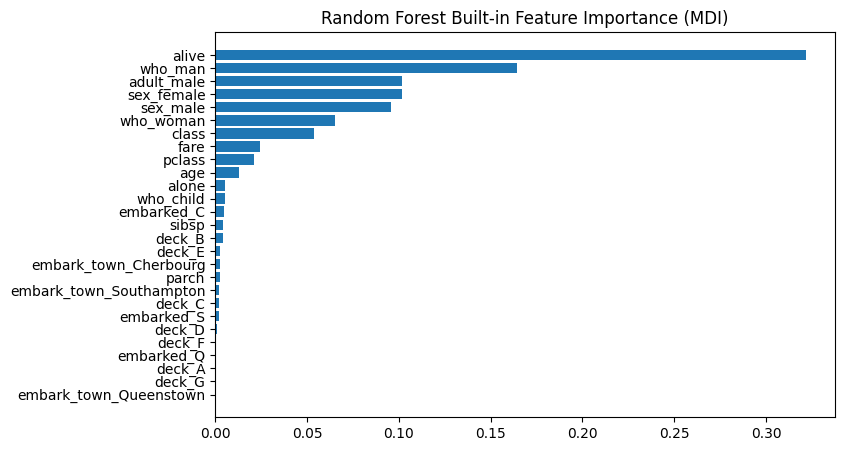

In [56]:
plt.figure(figsize=(8, 5))
plt.barh(feature_importance_sorted["feature"], feature_importance_sorted["importance"])
plt.gca().invert_yaxis()
plt.title("Random Forest Built-in Feature Importance (MDI)")
plt.show()

 Known biases of built‑in importance
- Biased toward features with many unique values.
Continuous features look more important than categorical ones.
- Biased when features are correlated, importance gets split or inflated.
- Does not reflect generalization It only measures training‑time impurity reduction. Generalization occurs, when model performs on data outside training set.

**Standard deviation calculation**

Standard deviation tells you stability of feature importance across trees.
- Low std → all trees agree the feature is important (or unimportant)
- High std → trees disagree; importance varies a lot
- Very high std → feature is used heavily in some trees but ignored in others


In [50]:
len(clf.estimators_)

138

And for each tree, we know its feature importance

In [51]:
clf.estimators_[0].feature_importances_.shape

(27,)

In [52]:
clf.estimators_[0].feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.27158152,
       0.        , 0.06483978, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.6635787 , 0.        , 0.        ,
       0.        , 0.        ])

In [59]:
feature_importance_df["importance_std"] = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

Ploting feature importance, together with Standard Devation.

Here we get STD larger than the mean, this is actually a plausible scenario.

It means that how individual trees disagree about the importance of each feature.

Ts perfectly possible since:
- Some trees use a feature heavily
- While other trees never use it


In [88]:
feature_importance_sorted = feature_importance_df.sort_values("importance", ascending=False)

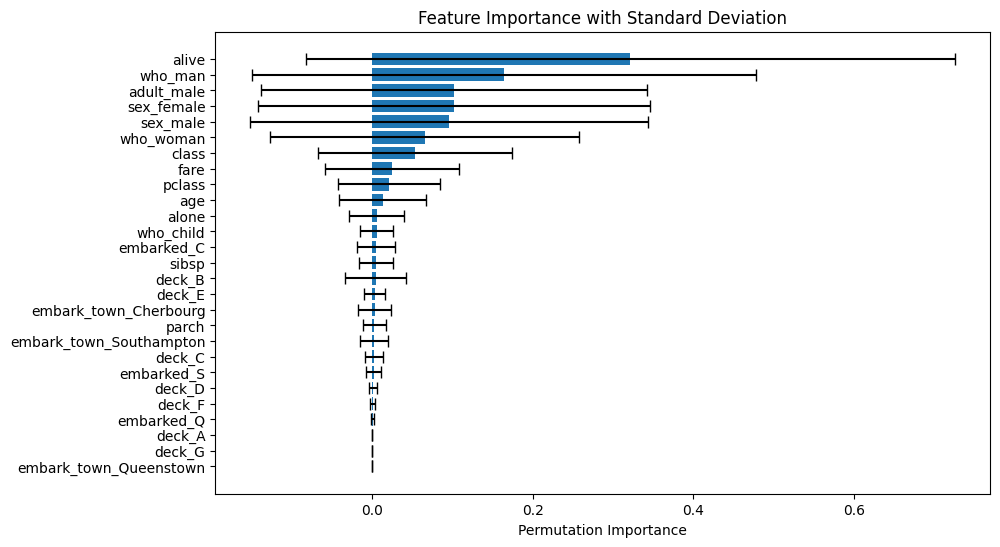

In [89]:
plt.figure(figsize=(10, 6))
plt.barh(
    feature_importance_sorted["feature"],
    feature_importance_sorted["importance"],
    xerr=feature_importance_sorted["importance_std"],
    capsize=4
)
plt.gca().invert_yaxis()  # highest importance at top
plt.xlabel("Permutation Importance")
plt.title("Feature Importance with Standard Deviation")
plt.show()

# 2.) Permutation importance from trained random forest

Permutation importance measures how much worse your model gets when you break one feature.

Essentialy you shuffle the values of a single column and you re-evaluate the results. This means that correlations between variable and targer are lost.

By corrupting the feature value, you then see how much importance did it have, based on how much results deteriorates.

In [62]:
from sklearn.inspection import permutation_importance

In [63]:
result = permutation_importance(clf, X, y, n_repeats=10, random_state=42)

In [67]:
permutation_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": result.importances_mean,
    "importance_std": result.importances_std,
}).sort_values("importance", ascending=False)

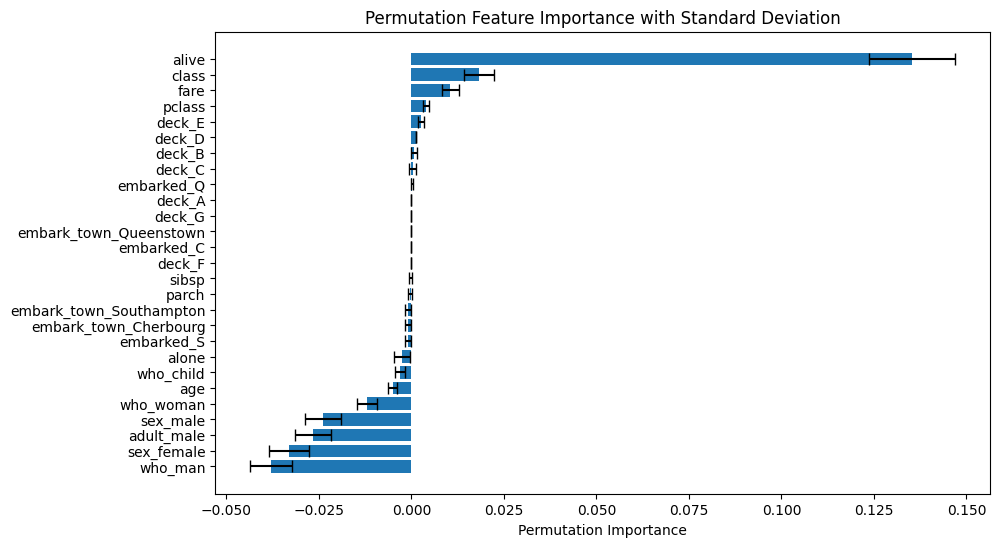

In [68]:
plt.figure(figsize=(10, 6))
plt.barh(
    permutation_importance["feature"],
    permutation_importance["importance"],
    xerr=permutation_importance["importance_std"],
    capsize=4
)
plt.gca().invert_yaxis()  # highest importance at top
plt.xlabel("Permutation Importance")
plt.title("Permutation Feature Importance with Standard Deviation")
plt.show()

# 3.) SHAP values

In [91]:
import shap

In [97]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

in practice since SHAP can take a lot of time on larger datasets, you calculate it on subsample.

Important, SHAP should be evaluated here on test/validation data, not on train data.

Because SHAP should explain how your model behaves on unseen data, not how it behaves on the data it already memorized.

Using SHAP on the training set gives you a distorted, overly optimistic view of feature importance.


X_sample = X.sample(2000)

In [103]:
shap_values.shape

(179, 27, 2)

You see from shape, one is all the samples used, another one is the columns length.

In [104]:
len(X_test), len(X_test.columns)

(179, 27)

But the number two are both predicted classes, since this is a binary problem, True or False

When using



- Use shap_values[:, :, 1]

  If you want to explain why the model predicts the positive class (the usual case).
- Use shap_values[:, :, 0]

  If you want to explain why the model predicts the negative class.


There are several ways how to vizualize SHAP

**1.) SHAP Bar Plot (global importance only):**

It shows mean absolute SHAP value per feature.
No direction, no color, no distribution, just how much each feature contributes on average.

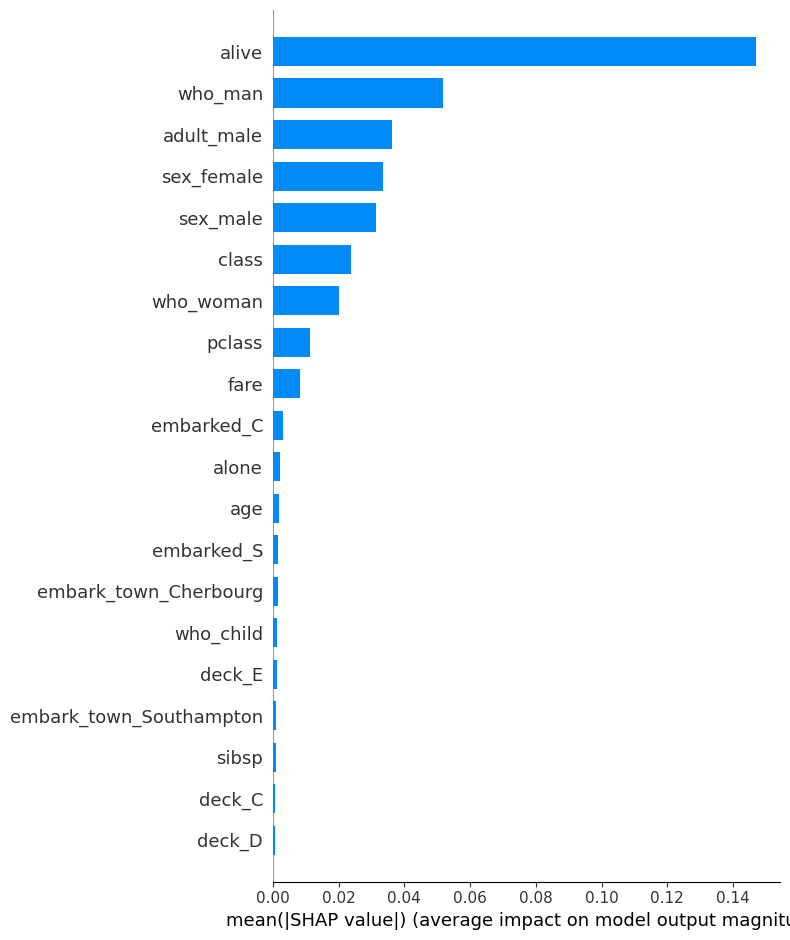

In [102]:
plt.figure()
shap.summary_plot(shap_values[:, :, 1], X_test, plot_type="bar")
plt.show()

**2.) SHAP Summary Plot (beeswarm):**

Global feature importance (top = most important)

1.) Direction of effect
- Red = high feature value
- Blue = low feature value

2.) Impact on prediction
- Points to the right  → push prediction toward class 1
- Points to the left → push prediction toward class 0

So for a strongly predictive feature, you typically see:

- Red points clustered on one side

    → high values push the model strongly toward class 1 (or class 0)
- Blue points clustered on the opposite side

    → low values push the model in the opposite direction

This “color separation” is a sign that the feature has a clear, directional effect on the prediction. If a feature is weak or noisy, the red/blue points will be mixed and centered around zero.


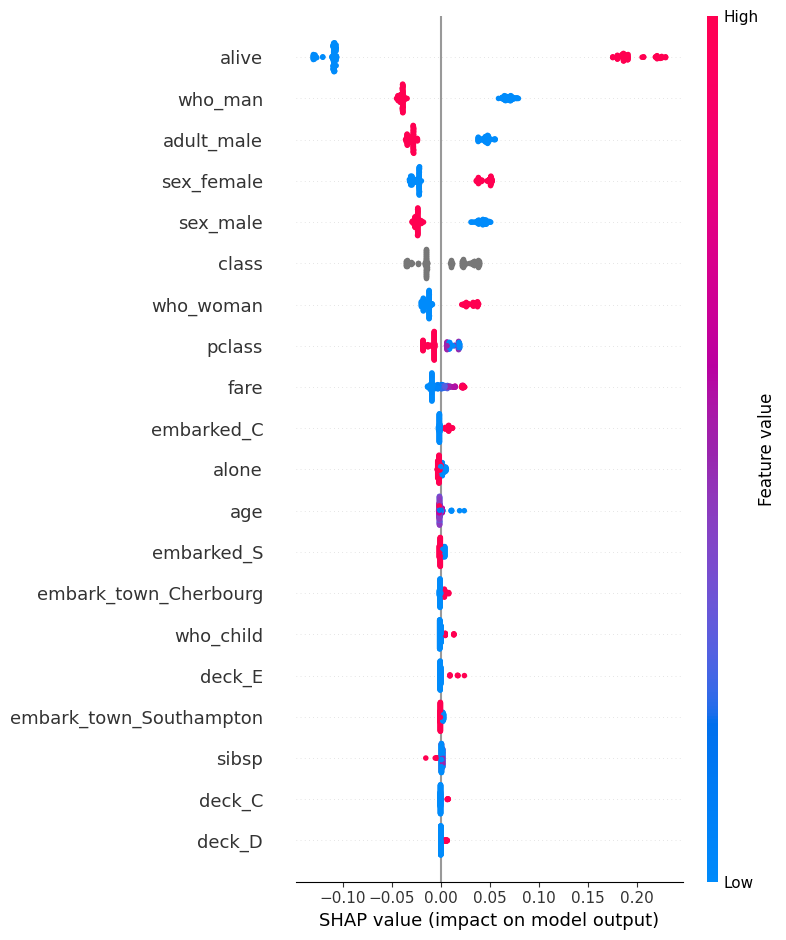

In [106]:
plt.figure()
shap.summary_plot(shap_values[:, :, 1], X_test)
plt.show()

**3.) Dependence plot for specific feature**

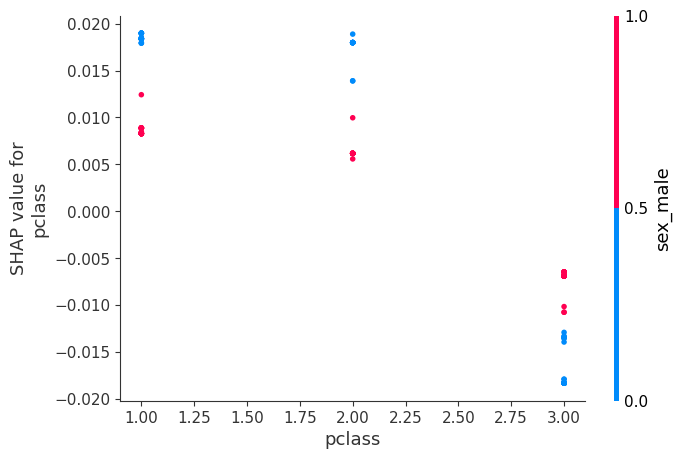

In [110]:
shap.dependence_plot("pclass", shap_values[:, :, 1], X_test)


# Same feature importance techniques also work with gradient boosting approaches

Both random Forest and Gradient Boosting are tree based models, so same approaches work on both.

**1. Built‑in Feature Importance, they have even more possible parameters:**



XGBoost built‑in importance types
- weight → number of times a feature is used in splits
- gain → average improvement in loss when feature is used
- cover → number of samples affected by splits using the feature
- total_gain, total_cover → sums instead of averages

```
model.get_booster().get_score(importance_type='gain')
```


LightGBM built‑in importance
- split → number of times feature used
- gain → total gain from splits

```
model.feature_importance(importance_type='gain')
```


CatBoost built‑in importance
- PredictionValuesChange (similar to gain)
- LossFunctionChange
- ShapValues (built‑in SHAP!)


```
model.get_feature_importance(type='PredictionValuesChange')
```






**2. Permutation Importance**

As seen in ddefinition is model agnostic,
model can be any implementation,
so any of:
- XGBoost
- LightGBM
- CatBoost


```
result = permutation_importance(model, X_val, y_val)
```



**3. SHAP Value**

Can also work on implementations like
- XGBoost
- LightGBM


```
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
```

CatBoost can compute SHAP values without SHAP library:


```
model.get_feature_importance(type='ShapValues')
```